# What are the most in-demand skills for the top three most common data roles?

### Methodology

1. Clean-up the `job_skills` column, converting the string representation of a Python list into an actual list.

2. Explode the `job_skills` column and calculating the skill counts based on `job_title short`.

3. Convert the job skills counts to percentages.

4. Plot the final finding.

### Import Libraries and Data

In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

### Filter Data for the United States

In [2]:
df_us = df[df['job_country'] == 'United States']

### Explode Skills and Count Skills per Job Title

Expanding the lists in the `job_skills` column so that each skill appears in its own row. Then, we display the `job_title_short` and `job_skils` columns, allowing us to analyze the distribution of skills across different data job titles.

In [5]:
df_skills = df_us.explode('job_skills')

df_skills[['job_title_short', 'job_skills']]

,job_title_short,job_skills
0,Senior Data Engineer,None
3,Data Engineer,python
3,Data Engineer,c++
3,Data Engineer,java
3,Data Engineer,matlab
...,...,...
785692,Data Scientist,r
785703,Data Analyst,None
785705,Data Analyst,sql
785705,Data Analyst,python


Now, we create a DataFrame by grouping `job_skills` and `job_title_short` and counting the occurrences of each skill within each job title. Then, we reset the index of the Series to convert it back into a DataFrame. Lastly, we sort the DataFrame by the `skill_count` to get final skills count DataFrame which shows the frequency of each skill with each job title.

In [6]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Name the count column as count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1209,python,Data Scientist,42379
1521,sql,Data Analyst,34452
1523,sql,Data Scientist,30034
455,excel,Data Analyst,27519
1243,r,Data Scientist,26022
...,...,...,...
245,clojure,Software Engineer,1
1738,vb.net,Senior Data Scientist,1
530,fortran,Machine Learning Engineer,1
1116,planner,Cloud Engineer,1


### Create a List of Top 3 Roles 

In [7]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

### Converting Counts to Percentages

Before we can convert counts to percentages, we need the total counts for the jobs posted by job title. We can derive the frequency of each job title using the value_counts() method on the job_title_short column. 

In [ ]:
# Use original df to get the count of job titles
df_job_title_count = df_us['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Analyst,67816
1,Data Scientist,58830
2,Data Engineer,35080
3,Senior Data Scientist,12946
4,Senior Data Analyst,11791
5,Senior Data Engineer,9289
6,Business Analyst,7382
7,Software Engineer,1814
8,Machine Learning Engineer,921
9,Cloud Engineer,423


Now that we have the job title counts, we can calculate the percentage of each skill within its job title by dividing the skill count by total job postings and mutiplying by 100.

In [9]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,python,Data Scientist,42379,58830,72.036376
1,sql,Data Analyst,34452,67816,50.802171
2,sql,Data Scientist,30034,58830,51.052184
3,excel,Data Analyst,27519,67816,40.578919
4,r,Data Scientist,26022,58830,44.232534
...,...,...,...,...,...
1865,clojure,Software Engineer,1,1814,0.055127
1866,vb.net,Senior Data Scientist,1,12946,0.007724
1867,fortran,Machine Learning Engineer,1,921,0.108578
1868,planner,Cloud Engineer,1,423,0.236407


### Plotting Percentage Count 

Filter and sort the DataFrame to get the top 5 highest skills percentages for these top 3 roles. After sorting the skills by descending percentage, reverse the order of these top 5 entries to use in a horizontal bar plot.

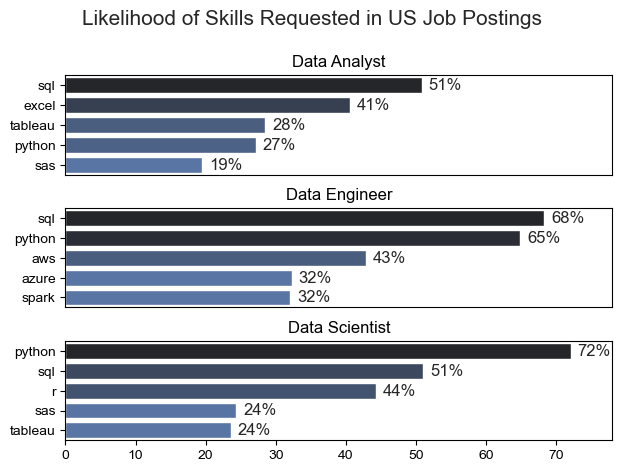

In [12]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style = 'ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 78)
    # remove the x-axis tick labels for better readability
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in US Job Postings', fontsize=15)
fig.tight_layout(h_pad=.8)
plt.show()